In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname="C:\Windows\Fonts\\malgun.ttf").get_name()
plt.rc("font", family=font_name)
import matplotlib as mlp
mlp.rcParams["axes.unicode_minus"] = False

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model       # model 생성
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate  # model 층 관련 모듈
from tensorflow.keras.layers import Conv2D, MaxPool2D                   # CNN
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D              # Max값으로 pooling해주는 함수
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, RMSprop              # optimizer
import tensorflow.keras.utils as utils                                  # one-hot encoding

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet  # TransferLearning
from tensorflow.keras.preprocessing.image import ImageDataGenerator     # 이미지 객체 생성해주는 모듈

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import random
import cv2
import zipfile
import shutil
import os
import glob

- https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
- TransferLearning & CNN 둘 다 해보기

# Project-1 : TransferLearning

### 경로 설정 & 데이터셋 가져오기

In [ ]:
#### Colab ####
from google.colab import drive

ROOT_DIR = "/content/"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "COVID_19")
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "train")
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "test")

drive.mount("/content/gdrive")
shutil.copy(os.path.join("/content/gdrive/MyDrive/Colab_Notebooks/", "COVID_19.zip"), ROOT_DIR)

if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)

with zipfile.ZipFile(os.path.join(ROOT_DIR, "COVID_19.zip"), "r") as target_file:
    target_file.extractall(DATA_ROOT_DIR)

In [4]:
#### PC ####
ROOT_DIR = "content"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "COVID_19")
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "train")
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "test")

if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)

with zipfile.ZipFile(os.path.join(ROOT_DIR, "COVID_19.zip"), "r") as target_file:
    target_file.extractall(DATA_ROOT_DIR)

### 필요한 폴더 및 파일들만 copy

In [30]:
#### 전체 목록 확인 ####
total_file_list = glob.glob(os.path.join(ROOT_DIR, "COVID-19_Radiography_Dataset/*"))
# print(total_file_list)

#### 정답리스트 추출 ####
label_name_list = [filename.split("\\")[-1].strip() 
                        for filename in total_file_list if os.path.isdir(filename) == True]  # 파일인 것만 가져오기
print(label_name_list)

#### 각 폴더의 images디렉토리를 train/정답이름 으로 복사 ####
for label_name in label_name_list:
    src_dir_path = os.path.join(ROOT_DIR, "COVID-19_Radiography_Dataset" + "/" + label_name + "/images")
    dst_dir_path = os.path.join(ROOT_DIR, "COVID-19_Radiography/train/" + label_name)
    
    try:
        shutil.copytree(src_dir_path, dst_dir_path)
        print(label_name + " copytree is done !")
    except Exception as err:
        print(err)

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
COVID copytree is done !
Lung_Opacity copytree is done !
Normal copytree is done !
Viral Pneumonia copytree is done !


### 전체 데이터 수 확인

In [32]:
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "COVID-19_Radiography")
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "train")
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "test")

train_file_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print("TRAIN")
print(train_file_list)
for i in range(len(train_file_list)):
    print(train_file_list[i], " =>  ", end="")
    print(len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, train_file_list[i]))))

TRAIN
['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
COVID  =>  3616
Lung_Opacity  =>  6012
Normal  =>  10192
Viral Pneumonia  =>  1345


### test 디렉토리 및 하위 디렉토리 생성

In [38]:
#### test 디렉토리 생성 ####
if not os.path.exists(TEST_DATA_ROOT_DIR):
    os.mkdir(TEST_DATA_ROOT_DIR)
    print(TEST_DATA_ROOT_DIR + " is created!")
else:
    print(TEST_DATA_ROOT_DIR + " already exists")

#### test 하위 디렉토리 생성 ####
for label_name in label_name_list:
    if not os.path.exists(os.path.join(TEST_DATA_ROOT_DIR, label_name)):
        os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))
        print(TEST_DATA_ROOT_DIR + "/" + label_name + " is created!")
    else:
        print(TEST_DATA_ROOT_DIR + "/" + label_name +  "already exists")

content\COVID-19_Radiography\test already exists
content\COVID-19_Radiography\test/COVID is created!
content\COVID-19_Radiography\test/Lung_Opacity is created!
content\COVID-19_Radiography\test/Normal is created!
content\COVID-19_Radiography\test/Viral Pneumonia is created!


### train -> test

In [39]:
MOVE_RATIO = 0.2

for label_name in label_name_list:
    src = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)   # 출발 경로
    dst = os.path.join(TEST_DATA_ROOT_DIR, label_name)    # 목적 경로
    
    train_data_file_list = os.listdir(src)
    
    print("=========================================================")
    print("total [%s] data file nums => [%s]"%(label_name, len(train_data_file_list)))
    
    np.random.shuffle(train_data_file_list)                  # 데이터 섞어주기
    print("train data shuffle is done!")
    
    split_num = int(MOVE_RATIO * len(train_data_file_list))  # 재이동시킬 데이터 수
    print("split nums =>", split_num)
    
    test_data_file_list = train_data_file_list[0:split_num]
    move_num = 0
    for test_data_file in test_data_file_list:
        shutil.move(os.path.join(src, test_data_file), os.path.join(dst, test_data_file))
        move_num += 1
    print("move nums =>", move_num, "(train -> test)")

total [COVID] data file nums => [3616]
train data shuffle is done!
split nums => 723
move nums => 723 (train -> test)
total [Lung_Opacity] data file nums => [6012]
train data shuffle is done!
split nums => 1202
move nums => 1202 (train -> test)
total [Normal] data file nums => [10192]
train data shuffle is done!
split nums => 2038
move nums => 2038 (train -> test)
total [Viral Pneumonia] data file nums => [1345]
train data shuffle is done!
split nums => 269
move nums => 269 (train -> test)


In [40]:
#### 훈련 데이터 수 ####
train_file_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print("TRAIN")
print(train_file_list)
for i in range(len(train_file_list)):
    print(train_file_list[i], " =>  ", end="")
    print(len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, train_file_list[i]))))

print("========================================================================")

#### 테스트 데이터 수 ####
test_file_list = os.listdir(TEST_DATA_ROOT_DIR)
print("TEST")
print(test_file_list)
for i in range(len(test_file_list)):
    print(test_file_list[i], " =>  ", end="")
    print(len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, test_file_list[i]))))

TRAIN
['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
COVID  =>  2893
Lung_Opacity  =>  4810
Normal  =>  8154
Viral Pneumonia  =>  1076
TEST
['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
COVID  =>  723
Lung_Opacity  =>  1202
Normal  =>  2038
Viral Pneumonia  =>  269


### ImageDataGenerator을 이용해서 데이터 불러오기

In [43]:
IMG_WIDTH = 100   # colab -> 224
IMG_HEIGHT = 100

train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_data_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode="rgb", 
                                                     target_size=(IMG_WIDTH, IMG_HEIGHT), class_mode="sparse",
                                                     subset="training")
val_generator = val_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode="rgb", 
                                                 target_size=(IMG_WIDTH, IMG_HEIGHT), class_mode="sparse", 
                                                 subset="validation")
test_generator = test_data_gen.flow_from_directory(directory=TEST_DATA_ROOT_DIR, batch_size=32, color_mode="rgb", 
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT), class_mode="sparse")

print("===============================================================================")
print(train_generator.class_indices)
print(train_generator.num_classes)

Found 13548 images belonging to 4 classes.
Found 3385 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.
{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
4


### 16장의 이미지 확인

(32, 100, 100, 3)


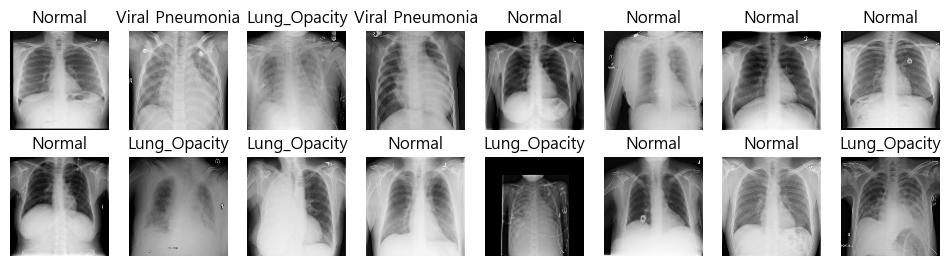

In [44]:
img, label = train_generator.next()
print(img.shape)

img = img[:16]
label = label[:16]

plt.figure(figsize=(12, 3))

for i in range(len(img)):
    plt.subplot(2, 8, i+1)
    plt.imshow(img[i])
    plt.axis("off")
    plt.title(list(train_generator.class_indices.keys())[int(label[i])])

### Fine Tunning을 위한 pre-trained 정의 및 모델 구축

In [46]:
pre_trained_model = MobileNet(weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

model = Sequential()

model.add(pre_trained_model)

# model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=1e-5), metrics=["accuracy"])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 64)                65600     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 3,294,724
Trainable params: 3,272,836
No

In [47]:
start = datetime.now()

result = model.fit(train_generator, epochs=3, validation_data=val_generator)

end = datetime.now()

print("걸린 시간 :", end-start)

Epoch 1/3
225/424 [==============>...............] - ETA: 1:02 - loss: 1.8892 - accuracy: 0.4160

KeyboardInterrupt: 

In [ ]:
model.evaluate(test_generator)
model.evaluate(val_generator)

In [ ]:
## 시각화 ##
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Loss function")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()
plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")

plt.subplot(1, 2, 2)
plt.title("Accuracy function")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()
plt.plot(result.history["accuracy"], label="train_accuracy")
plt.plot(result.history["val_accuracy"], label="validation_accuracy")
plt.legend(loc="best")